# Assignment 1 - Word2Vec
1.  Try a real corpus (instead of banana apple, try something real... on the internet....) - not so big!  

Just you have a good taste of real stuff....like 50 documents, each have 50 words....

2. Try window size of 2

3. Try CBOW (instead of skipgrams)

4. Compare normal version of skipgrams vs. negative sampling version of skipgrams in terms of time (using real corpus)

In [1]:
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import spacy
import pandas as pd
spacy.__version__

'3.4.2'

## 1 Load Data
A real corpus

In [2]:
nlp = spacy.load('./en_core_web_sm/')
text = open('./dataset/alchemist.txt',mode='r')
#credit corpus https://github.com/vilmibm/lovecraftcorpus 
df = pd.DataFrame(text.readlines())
df

,0
0,"High up, crowning the grassy summit of a swell..."
1,"But since those glorious years, all is changed..."
2,It was in one of the vast and gloomy chambers ...
3,"Thus isolated, and thrown upon my own resource..."
4,Of my own race I was permitted to learn singul...
5,The paper carried me back to the days of the t...
6,One night the castle on the hill was thrown in...
7,'May ne'er a noble of thy murd'rous line Survi...
8,"spake he, when, suddenly leaping backwards int..."
9,Thus time and the want of a reminder dulled th...


### Clean Data

In [3]:
def clean_data(df_col):
    corpus = []
    for item in df_col:
        item = re.sub('[^A-Za-z0-9]+', ' ', str(item)) # remove special characters
        item = item.lower() # lower all characters
        item = item.split() # split data
        corpus.append(' '.join(str(x) for x in item))
    return corpus

In [4]:
#1. tokenize
#data cleaned
corpus = clean_data(df[0])
#data tokenized
corpus_tokenized = [sent.split(" ") for sent in corpus]

In [5]:
#2. numericalize (vocab)
#2.1 get all the unique words
#we want to flatten unit (basically merge all list)
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs = list(set(flatten(corpus_tokenized)))

#2.2 assign id to all these vocabs
word2index = {v: idx for idx, v in enumerate(vocabs)}

#adding unknown word
vocabs.append('<UNK>')
word2index['<UNK>'] = len(vocabs) - 1

voc_size = len(vocabs)
voc_size

1233

In [6]:
#preparing all_vocabs
batch_size = 2

def prepare_seqeunce(seq, word2index):
    #map(fucntion, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_seqeunce(list(vocabs),word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 1233])

### Testing Skipgram and CBOW

In [7]:
skipgrams = []
cbows = []
for sent in corpus_tokenized:
    #for each sent ('apple', 'banana', 'fruit')
    for i in range(2,len(sent)-2): #start from 2 to second last
        center_word = sent[i]
        outside_word = [sent[i-2],sent[i-1],sent[i+1],sent[i+2]] #window size = 2
        for o in outside_word: 
            skipgrams.append([center_word,o])
        cbows.append([center_word, outside_word])

In [8]:
corpus[0]

'high up crowning the grassy summit of a swelling mount whose sides are wooded near the base with the gnarled trees of the primeval forest stands the old chateau of my ancestors for centuries its lofty battlements have frowned down upon the wild and rugged countryside about serving as a home and stronghold for the proud house whose honored line is older even than the moss grown castle walls these ancient turrets stained by the storms of generations and crumbling under the slow yet mighty pressure of time formed in the ages of feudalism one of the most dreaded and formidable fortresses in all france from its machicolated parapets and mounted battlements barons counts and even kings had been defied yet never had its spacious halls resounded to the footsteps of the invader'

In [9]:
skipgrams[:5]

[['crowning', 'high'],
 ['crowning', 'up'],
 ['crowning', 'the'],
 ['crowning', 'grassy'],
 ['the', 'up']]

In [10]:
cbows[:5]

[['crowning', ['high', 'up', 'the', 'grassy']],
 ['the', ['up', 'crowning', 'grassy', 'summit']],
 ['grassy', ['crowning', 'the', 'summit', 'of']],
 ['summit', ['the', 'grassy', 'of', 'a']],
 ['of', ['grassy', 'summit', 'a', 'swelling']]]

In [11]:
skipgrams = []
cbows = []
window_size = 2
#for each corpus
for sent in corpus_tokenized:
    #for each sent ('apple', 'banana', 'fruit')
    for i in range(window_size,len(sent)-window_size): #start from 2 to second last
        context_word = []
        # print(sent[i])
        center_word = sent[i]
        for j in range(window_size):
            outside_word = [sent[i-j-1],sent[i+j+1]] #window_size adjustable
            #here we want to create (banana, apple), (banana, fruit) append to some list
            for o in outside_word:
                context_word.append(o)
                skipgrams.append([center_word,o])
            cbows.append([context_word,center_word])

In [12]:
skipgrams[:5]

[['crowning', 'up'],
 ['crowning', 'the'],
 ['crowning', 'high'],
 ['crowning', 'grassy'],
 ['the', 'crowning']]

In [13]:
cbows[:5]

[[['up', 'the', 'high', 'grassy'], 'crowning'],
 [['up', 'the', 'high', 'grassy'], 'crowning'],
 [['crowning', 'grassy', 'up', 'summit'], 'the'],
 [['crowning', 'grassy', 'up', 'summit'], 'the'],
 [['the', 'summit', 'crowning', 'of'], 'grassy']]

### Set random_batch

In [14]:
def random_batch(batch_size, corpus, window_size=1,architecture='skipgram'):
    skipgrams = []
    cbows = []
    #for each corpus
    for sent in corpus_tokenized:
        #for each sent ('apple', 'banana', 'fruit')
        for i in range(window_size,len(sent)-window_size): #start from 2 to second last
            context_word = []
            # print(sent[i])
            center_word = word2index[sent[i]]
            for j in range(window_size):
                outside_word = [word2index[sent[i-j-1]],word2index[sent[i+j+1]]] #window_size adjustable
                #here we want to create (banana, apple), (banana, fruit) append to some list
                for o in outside_word:
                    context_word.append(o)
                    skipgrams.append([center_word,o])
                cbows.append([context_word,center_word])

    if architecture == 'skipgram':
        arch = skipgrams
    else:
        arch = cbows
        
    #only get a batch, not the entire lsit
    random_index = np.random.choice(range(len(arch)),batch_size,replace=False)
    #appending some list of inputs and labels
    random_inputs, random_labels = [] , []
    for index in random_index:
        # print(arch[index])
        random_inputs.append([arch[index][0]]) #center words, this will be as shape of (1,) -> (1,1) for modeling
        random_labels.append([arch[index][1]])

    return np.array(random_inputs),np.array(random_labels)

In [15]:
batch_size = 2 
input_batch, label_batch = random_batch(batch_size,corpus,window_size=2,architecture='skipgram')
input_batch = torch.LongTensor(input_batch)
label_batch = torch.LongTensor(label_batch)
input_batch.shape,label_batch.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [16]:
input_batch,label_batch

(tensor([[632],
         [855]]),
 tensor([[825],
         [171]]))

## 2.1 Continuous Bag-of-Words (CBOW)

### CBOW Model

In [17]:
class CBOW(nn.Module): #same as skipgram
    def __init__(self,voc_size, emb_size):
        super(CBOW,self).__init__()
        self.embedding_center_word = nn.Embedding(voc_size, emb_size) #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #center_word, outside_word: (batch_size,1)
        #all_vocabs : (batch_size, voc_size)
        #convert them into embedding
        center_word_embed = self.embedding_center_word(center_word)     #v_c (batch_size,1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)  #u_o (batch_size,1, emb_size)
        all_vocabs_embed = self.embedding_outside_word(all_vocabs)      #u_w (batch_size,voc_size, emb_size)
        # print(center_word_embed.shape,outside_word_embed.shape,all_vocabs_embed.shape)
        #bmm is basically @ or .dot but across batches (ie., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1,2)).squeeze(2)
        #(batch_size,1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        top_term_exp = torch.exp(top_term) #exp(uo vc)
        #(batch_size, 1)
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1,2)).squeeze(2)
        #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) ===> (batch_size, voc_size)
        lower_term_sum = torch.sum(torch.exp(lower_term)) #sum exp(uw, vc)
        #(batch_size, 1)
        loss_fn = -torch.mean(torch.log(top_term_exp/lower_term_sum))
        #(batc_size,1) / (batch_size,1) ==mena==> scalar
        return loss_fn

In [18]:
batch_size = 2 #why? no reason
emb_size = 2 #why? no reason; usually 50,100, 300 but 2 so we can plot (50 can also plot, but need PCA)
model = CBOW(voc_size,emb_size)

criterion = nn.CrossEntropyLoss() #-log
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
input_batch, label_batch = random_batch(batch_size,corpus,window_size=2,architecture='cbow')
input_batch = torch.LongTensor(input_batch).view(batch_size,window_size*2)
label_batch = torch.LongTensor(label_batch)
input_batch.shape,label_batch.shape,all_vocabs.shape

(torch.Size([2, 4]), torch.Size([2, 1]), torch.Size([2, 1233]))

In [29]:
input_batch,label_batch

(tensor([[1209,  825,  539,  539],
         [ 825,  372, 1048,  977]]),
 tensor([[891],
         [711]]))

### training

In [31]:
import time
num_epochs = 5000
#for epoch
start = time.time()
for epoch in range(num_epochs):
    
    #get random batch
    input_batch, label_batch = random_batch(batch_size,corpus,window_size=2,architecture='cbow')
    input_batch = torch.LongTensor(input_batch).view(batch_size,window_size*2)
    label_batch = torch.LongTensor(label_batch).view(-1,1)

    # print(input_batch.shape,label_batch.shape,all_vocabs.shape)
    # break

    #loss = model
    loss = model(input_batch,label_batch,all_vocabs)
    
    #backpropagate
    loss.backward()
    #update alpha
    optimizer.step()

    end = time.time()
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {end-start}")
    # break

Epoch: 1000 | cost: 8.358817 | time: 37.99840807914734
Epoch: 2000 | cost: 7.949036 | time: 77.60742712020874
Epoch: 3000 | cost: 9.626275 | time: 116.13375210762024
Epoch: 4000 | cost: 8.819651 | time: 153.54697179794312
Epoch: 5000 | cost: 8.368521 | time: 194.2713499069214


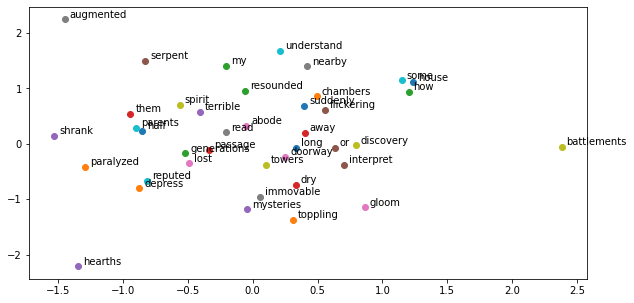

In [32]:
def get_embed(word):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (model.embedding_center_word(word)+model.embedding_outside_word(word))/2
    return embed[0][0].item(),embed[0][1].item()

#help me plot fruit cat banana on maplotlib
plt.figure(figsize=(10,5))
for i, word in enumerate(vocabs[:40]):
    x,y = get_embed(word)
    plt.scatter(x,y)
    plt.annotate(word,xy=(x,y),xytext=(5,2),textcoords='offset points')
plt.show()

# Compare normal version of skipgrams vs. negative sampling version of skipgrams in terms of time (using real corpus)

## 2.2 Skipgram

### Skipgram Model

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [33]:
class Skipgram(nn.Module):
    def __init__(self,voc_size, emb_size):
        super(Skipgram,self).__init__()
        self.embedding_center_word = nn.Embedding(voc_size, emb_size) #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #center_word, outside_word: (batch_size,1)
        #all_vocabs : (batch_size, voc_size)
        #convert them into embedding
        center_word_embed = self.embedding_center_word(center_word)     #v_c (batch_size,1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)  #u_o (batch_size,1, emb_size)
        all_vocabs_embed = self.embedding_outside_word(all_vocabs)      #u_w (batch_size,voc_size, emb_size)
        # print(center_word_embed.shape,outside_word_embed.shape,all_vocabs_embed.shape)
        #bmm is basically @ or .dot but across batches (ie., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1,2)).squeeze(2)
        #(batch_size,1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        top_term_exp = torch.exp(top_term) #exp(uo vc)
        #(batch_size, 1)
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1,2)).squeeze(2)
        #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) ===> (batch_size, voc_size)
        lower_term_sum = torch.sum(torch.exp(lower_term)) #sum exp(uw, vc)
        #(batch_size, 1)
        loss_fn = -torch.mean(torch.log(top_term_exp/lower_term_sum))
        #(batc_size,1) / (batch_size,1) ==mena==> scalar
        return loss_fn

In [34]:
batch_size = 2 #why? no reason
emb_size = 2 #why? no reason; usually 50,100, 300 but 2 so we can plot (50 can also plot, but need PCA)
model = Skipgram(voc_size,emb_size)

criterion = nn.CrossEntropyLoss() #-log
optimizer = optim.Adam(model.parameters(), lr=0.001)

### training

In [35]:
import time
num_epochs = 5000
#for epoch
start = time.time()
for epoch in range(num_epochs):
    
    #get random batch
    input_batch, label_batch = random_batch(batch_size,corpus,window_size=2,architecture='skipgram')
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)

    # print(input_batch.shape,label_batch.shape,all_vocabs.shape)
    # break

    #loss = model
    loss = model(input_batch,label_batch,all_vocabs)
    #backpropagate
    loss.backward()
    #update alpha
    optimizer.step()

    end = time.time()

    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {end-start}")

Epoch: 1000 | cost: 7.848458 | time: 36.797977685928345
Epoch: 2000 | cost: 9.061180 | time: 73.5460467338562
Epoch: 3000 | cost: 7.682127 | time: 113.46555972099304
Epoch: 4000 | cost: 7.824592 | time: 153.02008748054504
Epoch: 5000 | cost: 6.580796 | time: 191.13698363304138


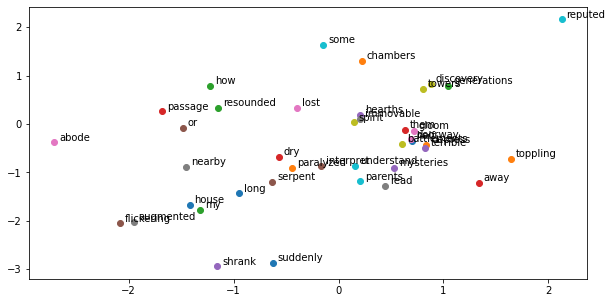

In [36]:
def get_embed(word):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (model.embedding_center_word(word)+model.embedding_outside_word(word))/2
    return embed[0][0].item(),embed[0][1].item()

#help me plot fruit cat banana on maplotlib
plt.figure(figsize=(10,5))
for i, word in enumerate(vocabs[:40]):
    x,y = get_embed(word)
    plt.scatter(x,y)
    plt.annotate(word,xy=(x,y),xytext=(5,2),textcoords='offset points')
plt.show()

## 2.3 Negative Sampling

### Unigram Distribution

$$P(w)=U(w)^{3/4}/Z$$

Defining the probability of sampling negative words

In [37]:
##Unigram Distribution
z = 0.0001
#count all the occurence of vocabs
from collections import Counter

word_count = Counter(flatten(corpus_tokenized))
word_count

num_total_words = sum([c for w, c in word_count.items()])
num_total_words

unigram_table = []

for v in vocabs:
    uw = word_count[v]/num_total_words
    uw_alpha = uw ** 0.75
    uw_alpha_dividebyz = int(uw_alpha/z)
    # print('Vocab :',v)
    # print('distribution :', uw_alpha_dividebyz)
    unigram_table.extend([v] * uw_alpha_dividebyz)

# Counter(unigram_table)

In [38]:
def prepare_sequence(seq, word2index):
    #map(fucntion, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)
    
import random
#you don't want to pick samples = targets, basically negative samples
#k = number of negative samples - how many? they found 10 is the best
#will be run during training
#after random_batch, 
def negative_sampling(targets, unigram_table, k):
    #targets is already in id.....
    #but the unigram_table is in word....
    #1. get the batch size of this targets
    batch_size = targets.shape[0]
    neg_samples = []
    #2. for each batch
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            #if this word == target, skip this word
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #tensor[], tensor[]
    return torch.cat(neg_samples)  #tensor[[], []]

In [39]:
num_neg = 2 # in the real code, we gonna use 10 (like in the paper)
neg_samples = negative_sampling(label_batch, unigram_table, num_neg)
# neg_samples[0].shape
neg_samples.shape 

torch.Size([2, 2])

### Negative Sampling Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [40]:
#the model will accept three vectors - u_o, v_c, u_k
#u_o - vectos for outside words
#v_C - vector for center word
#u_k - vectors for negative word

class SkipgramNeg(nn.Module):
    def __init__(self,voc_size, emb_size):
        super(SkipgramNeg,self).__init__()
        self.embedding_center_word = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()

    def forward(self, center_words, outside_words, negative_words):
        #center_words, outside_words  (batch_size,1)
        #negative_words (batch_size,k) 
        center_embed    = self.embedding_center_word(center_words)      #(batch_size,1, emb_size)
        outside_embed   = self.embedding_outside_word(outside_words)   #(batch_size,1, emb_size)
        neg_embed       = self.embedding_outside_word(negative_words)      #(batch_size,k, emb_size)
        
        uovc            = outside_embed.bmm(center_embed.transpose(1,2)).squeeze(2)
        ukvc            = -neg_embed.bmm(center_embed.transpose(1,2)).squeeze(2)
        ukvc_sum        =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum) #(batch_size,1)+(batch_size,1)
        
        return -torch.mean(loss) #scalar, loss should be scalar, to call backward()

In [41]:
voc_size = len(vocabs)
voc_size

batch_size = 2 #why? no reason
emb_size = 2 #why? no reason; usually 50,100, 300 but 2 so we can plot (50 can also plot, but need PCA)
model = SkipgramNeg(voc_size,emb_size)

criterion = nn.CrossEntropyLoss() #-log
optimizer = optim.Adam(model.parameters(), lr=0.001)

### training

In [42]:
import time

# Training
num_epochs = 5000
start = time.time()
for epoch in range(num_epochs):
    
    input_batch, target_batch = random_batch(batch_size, corpus,window_size=2)
    
    #input_batch: [batch_size, 1]
    input_batch = torch.LongTensor(input_batch)
    #target_batch: [batch_size, 1]
    target_batch = torch.LongTensor(target_batch)
    #negs_batch:   [batch_size, num_neg]
    negs_batch = negative_sampling(target_batch, unigram_table, num_neg)
    
    optimizer.zero_grad()
        
    loss = model(input_batch, target_batch, negs_batch)
    
    end = time.time()
    
    loss.backward()
    optimizer.step()
    
    #print loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {end - start :.2f}")

Epoch: 1000 | cost: 2.049604 | time: 39.16
Epoch: 2000 | cost: 2.222557 | time: 81.42
Epoch: 3000 | cost: 1.339581 | time: 122.00
Epoch: 4000 | cost: 1.940662 | time: 163.70
Epoch: 5000 | cost: 1.662373 | time: 207.02


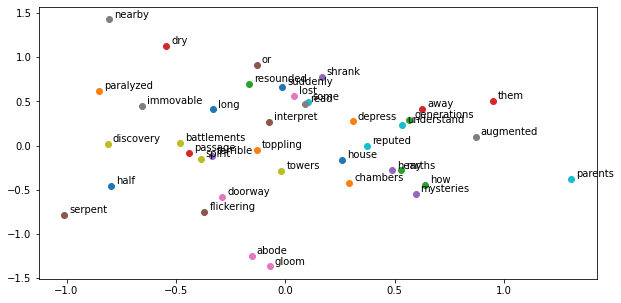

In [43]:
def get_embed(word):
    try:
        index = word2index[word]
    except :
        index = word2index['<UNK>'] #unknown
    word = torch.LongTensor([index])
    
    embed =  (model.embedding_center_word(word)+model.embedding_outside_word(word))/2
    return embed[0][0].item(),embed[0][1].item()

#help me plot fruit cat banana on maplotlib
plt.figure(figsize=(10,5))
for i, word in enumerate(vocabs[:40]):
    x,y = get_embed(word)
    plt.scatter(x,y)
    plt.annotate(word,xy=(x,y),xytext=(5,2),textcoords='offset points')
plt.show()

# Appendix

## Example to import db file

In [ ]:
import pandas as pd
import sqlite3
def ReadSQL(filename):
    connection = sqlite3.connect(filename)
    data = pd.read_sql("SELECT * from city_table",connection)
    return data

ReadSQL('./dataset/city.db')
#It doesn't use it